In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import wandb

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


c:\Users\grk\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Seed:  999


In [2]:
image_size = 64
batch_size = 256
ngpu = 1
workers = 4
ndf = 64
num_epochs = 100
latent_dim = 100

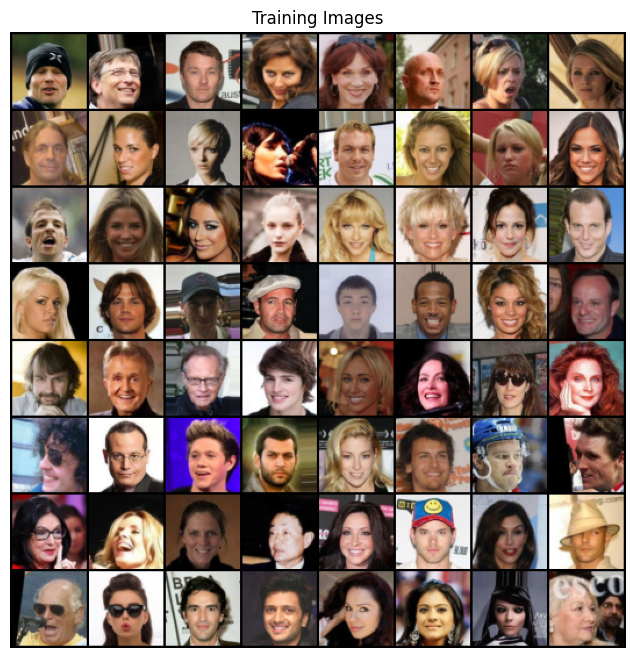

In [3]:
dataset = dset.ImageFolder("celeba", transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Создаем даталоадер
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Выбираем девайс для вычислений
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Нарисуем часть картинок из датасета
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# кастомная инициализация весов netG или netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [5]:
class CSPup(nn.Module):
    def __init__(self, in_channels):
        super(CSPup, self).__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels // 2
        self.block1 = nn.Sequential(
            nn.Conv2d(self.out_channels, out_channels=self.out_channels, kernel_size= 1, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.out_channels, self.out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(self.out_channels, out_channels=self.out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.out_channels, out_channels=self.out_channels, kernel_size=3, padding=1),
        )
        self.skip_upscale = nn.ConvTranspose2d(self.out_channels, self.out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        xs, xb = x.split(self.out_channels, dim=1)
        xb = self.block1(xb)
        xb = self.block2(xb)
        xs = self.skip_upscale(xs)
        out = xs + xb
        return out

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dims):
        super(Generator, self).__init__()
        self.linear = nn.Linear(latent_dims, 4*4*1024)
        self.upscale = nn.Sequential(
            CSPup(1024),
            CSPup(512),
            CSPup(256),
        )
        self.final = nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(-1,1024,4,4)
        x = self.upscale(x)
        out = self.final(x)
        return out

In [7]:
# Инициализируем генератор
netG = Generator(latent_dim).to(device)

# Инициализируем веса
netG.apply(weights_init)

Generator(
  (linear): Linear(in_features=100, out_features=16384, bias=True)
  (upscale): Sequential(
    (0): CSPup(
      (block1): Sequential(
        (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      )
      (block2): Sequential(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (skip_upscale): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    )
    (1): CSPup(
      (block1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      )
      (block2): Sequential(
        (0): Conv2d(256

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# инициализируем дискриминатор
netD = Discriminator().to(device)

# Инициализируем веса
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [10]:
# Инициализируем лосс
criterion = nn.BCELoss()

# Создаем батч с рандомным шумом для генерации
fixed_noise = torch.randn(64, latent_dim, device=device)

# Метки для реальных данных и фековых
real_label = 1.
fake_label = 0.


# Устанавливаем оптимизаторы для G и D
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [27]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
wandb.init(project="csp-gan")
print("Starting Training Loop...")
# Для каждой эпохи
for epoch in range(num_epochs):
    # Для каждого батча
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Учим дискриминатор: максимизируем log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Для батча
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Прямой прогон батча из реальных картинок D
        output = netD(real_cpu).view(-1)
        # Считаем лосс на всем батче реальных картинок
        errD_real = criterion(output, label)
        # Вычисляем градиенты для дискриминатора
        errD_real.backward()
        D_x = output.mean().item()

        ## Учим на полном фейковом батче
        # Генерируем бат латентных векторов
        noise = torch.randn(b_size, latent_dim, device=device)
        # Генерируем фековый батч с помощью G
        fake = netG(noise)
        label.fill_(fake_label)
        # Классифицируем фековый батч с помощью D
        output = netD(fake.detach()).view(-1)
        # Вычисляем лосс дискриминатора на фейковом батче
        errD_fake = criterion(output, label)
        # Вычисляем градиент для фейкового батча, он суммируется с предидущим
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Вычисляем ошибку на реальном и фековом батчах
        errD = errD_real + errD_fake
        # Обновляем веса D
        optimizerD.step()

        ############################
        # (2) Учим генератор: максимизируем log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # для генератора фейковые метки есть реальные (0 меняем на 1)
        # Так как мы обновили веса дискриминатора прогоним фековый батч через него еще  раз
        output = netD(fake).view(-1)
        # Вычислим лосс G основываясь на выходе D
        errG = criterion(output, label)
        # Вычислим градиент для G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Обновляем веса G
        optimizerG.step()

        # Выводим статистику обучения
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            wandb.log({
                "Loss_D": errD.item(),
                "Loss_G": errG.item(),
                "D(x)": D_x,
            })

        # Сохраним лоссы
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Проверим какие картинки рисует генератор
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            #img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            images = wandb.Image(vutils.make_grid(fake, padding=2, normalize=True))
            wandb.log({"Generated": images})

        iters += 1

D(x),▁█
Loss_D,█▁
Loss_G,▁█
D(x),0.74428
Loss_D,1.74
Loss_G,14.68853


Starting Training Loop...
[0/100][0/792]	Loss_D: 0.5647	Loss_G: 2.8284	D(x): 0.7748	D(G(z)): 0.1788 / 0.0941
[0/100][50/792]	Loss_D: 1.5740	Loss_G: 4.4487	D(x): 0.7537	D(G(z)): 0.6349 / 0.0224
[0/100][100/792]	Loss_D: 1.3431	Loss_G: 1.8621	D(x): 0.4937	D(G(z)): 0.3055 / 0.1999
[0/100][150/792]	Loss_D: 1.4672	Loss_G: 1.5668	D(x): 0.4256	D(G(z)): 0.2513 / 0.2648
[0/100][200/792]	Loss_D: 1.4198	Loss_G: 2.9787	D(x): 0.7000	D(G(z)): 0.5649 / 0.0864
[0/100][250/792]	Loss_D: 0.8328	Loss_G: 3.0103	D(x): 0.7683	D(G(z)): 0.3816 / 0.0721
[0/100][300/792]	Loss_D: 0.9238	Loss_G: 2.8687	D(x): 0.7937	D(G(z)): 0.4324 / 0.0937
[0/100][350/792]	Loss_D: 1.1798	Loss_G: 2.2643	D(x): 0.7193	D(G(z)): 0.5155 / 0.1302
[0/100][400/792]	Loss_D: 0.8912	Loss_G: 1.7590	D(x): 0.7474	D(G(z)): 0.4091 / 0.2088
[0/100][450/792]	Loss_D: 1.2640	Loss_G: 1.9194	D(x): 0.5221	D(G(z)): 0.3370 / 0.1824
[0/100][500/792]	Loss_D: 1.2168	Loss_G: 1.6250	D(x): 0.5282	D(G(z)): 0.3488 / 0.2289
[0/100][550/792]	Loss_D: 1.6101	Loss_G: 3.

KeyboardInterrupt: 

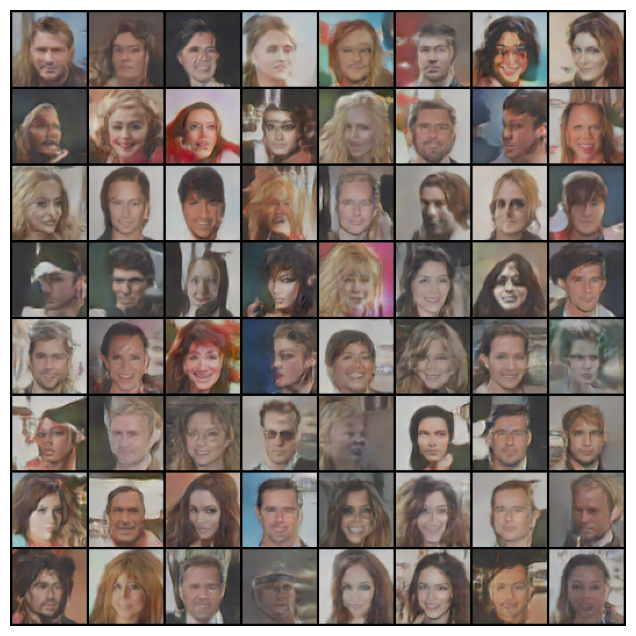

In [281]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
np.transpose(img_list[0],(1,2,0))

In [293]:
530/8

66.25

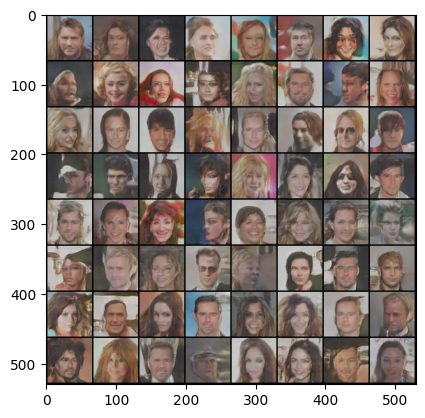

In [298]:
plt.imshow(img_list[0].permute(1,2,0).numpy())

In [294]:
ims

[[<matplotlib.image.AxesImage at 0x1ccc518a940>]]

In [13]:
grid = vutils.make_grid(fake, padding=2, normalize=True)
images = wandb.Image(grid)
wandb.log({
    "Generated fakes": images
})

In [20]:
grid.shape

torch.Size([3, 2114, 530])

In [26]:
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    images = wandb.Image(vutils.make_grid(fake, padding=2, normalize=True))
    wandb.log({"Generated": images})


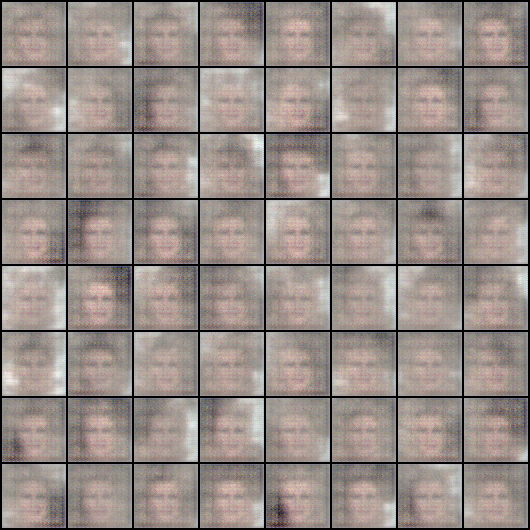

In [22]:
images.image